#  **MULTI-TASK LEARNING**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Research Kernel Link - https://arxiv.org/pdf/2003.02261.pdf

import pandas as pd
import numpy as np
import itertools
import os
import sys
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
from tqdm import tqdm_notebook
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation,BatchNormalization,GlobalMaxPooling2D,concatenate,Flatten
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,Callback
from keras.initializers import random_normal
from keras.models import load_model
from keras.losses import binary_crossentropy,categorical_crossentropy,mean_squared_error
from keras import backend as K

import tensorflow as tf
#import shap

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

2  CPU cores


## **Setup Colab Environment**


In [ ]:
'''
The codes below uses Authentication URL to allow loading of Files and Images from Google Drive to Colab Memory
'''

In [ ]:
# Importing Libraries
#ref - https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/PROJECTS/Deep learning/Diabetic retinopathy detection/dataset/aptos2019-blindness-detection')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/PROJECTS/Deep learning/Diabetic retinopathy detection/dataset/aptos2019-blindness-detection


## **Load data and preprocess**


In [ ]:
'''
Loading Train and Validation Data from Previously split Train/Test data
'''

In [ ]:
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_test', 'rb')
    df_train_test = pickle.load(file)
    file.close()
    
    return df_train_train,df_train_test

In [ ]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(2929, 4) (733, 4) 



,id_code,diagnosis,file_path,file_name
684,30cab14951ac,1,/content/drive/MyDrive/PROJECTS/Deep learning/...,30cab14951ac.png
1332,5ca73d28f17f,0,/content/drive/MyDrive/PROJECTS/Deep learning/...,5ca73d28f17f.png
768,3710ff45299c,0,/content/drive/MyDrive/PROJECTS/Deep learning/...,3710ff45299c.png
2019,8dfff47b06b7,2,/content/drive/MyDrive/PROJECTS/Deep learning/...,8dfff47b06b7.png
683,30941b65348b,1,/content/drive/MyDrive/PROJECTS/Deep learning/...,30941b65348b.png
3638,fe3f62695b2d,0,/content/drive/MyDrive/PROJECTS/Deep learning/...,fe3f62695b2d.png


In [ ]:
print(len(os.listdir("./train_images_resized_preprocessed/")),len(os.listdir("./test_images_resized_preprocessed/")))

2929 733


In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
df_train_new_train,df_train_valid = train_test_split(df_train_train,test_size = 0.2)
print(df_train_new_train.shape,df_train_valid.shape)
#df_train_new_train.tail(6)
df_train_valid.tail(6)

(2343, 4) (586, 4)


,id_code,diagnosis,file_path,file_name
2013,8d9516ea3587,0,/content/drive/MyDrive/PROJECTS/Deep learning/...,8d9516ea3587.png
1407,6298468d7d75,1,/content/drive/MyDrive/PROJECTS/Deep learning/...,6298468d7d75.png
376,1bb0ddfe753a,1,/content/drive/MyDrive/PROJECTS/Deep learning/...,1bb0ddfe753a.png
1952,898f0bc8acfa,0,/content/drive/MyDrive/PROJECTS/Deep learning/...,898f0bc8acfa.png
319,18323d8f2470,2,/content/drive/MyDrive/PROJECTS/Deep learning/...,18323d8f2470.png
2839,c561bcd519e9,2,/content/drive/MyDrive/PROJECTS/Deep learning/...,c561bcd519e9.png


In [ ]:

file = open('/content/drive/MyDrive/PROJECTS/Deep learning/Diabetic retinopathy detection/dataset/aptos2019-blindness-detection/df_train_new_train', 'wb')
pickle.dump(df_train_new_train, file)
file.close()

file = open('/content/drive/MyDrive/PROJECTS/Deep learning/Diabetic retinopathy detection/dataset/aptos2019-blindness-detection/df_train_valid', 'wb')
pickle.dump(df_train_valid, file)
file.close()


file = open('/content/drive/MyDrive/PROJECTS/Deep learning/Diabetic retinopathy detection/dataset/aptos2019-blindness-detection/df_train_new_train', 'rb')
df_train_new_train = pickle.load(file)
file.close()

file = open('/content/drive/MyDrive/PROJECTS/Deep learning/Diabetic retinopathy detection/dataset/aptos2019-blindness-detection/df_train_valid', 'rb')
df_train_valid = pickle.load(file)
file.close()

In [ ]:
'''
Defining Global Variables to be used in this notebook
'''
FACTOR = 4
BATCH_SIZE = 8 * FACTOR
IMG_SIZE = 512
EPOCHS = 20
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4 * FACTOR
WARMUP_LEARNING_RATE = 1e-3 * FACTOR
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

LR_WARMUP_EPOCHS_1st = 2
LR_WARMUP_EPOCHS_2nd = 5
STEP_SIZE = len(df_train_train) // BATCH_SIZE
TOTAL_STEPS_1st = WARMUP_EPOCHS * STEP_SIZE
TOTAL_STEPS_2nd = EPOCHS * STEP_SIZE
WARMUP_STEPS_1st = LR_WARMUP_EPOCHS_1st * STEP_SIZE
WARMUP_STEPS_2nd = LR_WARMUP_EPOCHS_2nd * STEP_SIZE

## **Custom Image Data generator**


In [ ]:
'''
This Function creates a custom Image Data generator, 
Since this is a Multi Output Model, a custom Image data generator is used (which yeild's outputs to next iterator)
'''

"\nThis Function creates a custom Image Data generator, \nSince this is a Multi Output Model, a custom Image data generator is used (which yeild's outputs to next iterator)\n"

In [ ]:
# custom generator ref - https://classifai.net/blog/multiple-outputs-keras/
# ref - https://stackoverflow.com/questions/54143458/convert-categorical-data-back-to-numbers-using-keras-utils-to-categorical

def multiple_outputs(generator,dataframe, image_dir, batch_size, height,width, subset):
    gen = generator.flow_from_dataframe(
        dataframe = dataframe,
        x_col = "file_name",
        y_col = "diagnosis",
        directory = image_dir,
        target_size=(height, width),
        batch_size=batch_size)
        #class_mode='categorical',
        #subset=subset)
    
    mlb = MultiLabelBinarizer(classes = range(N_CLASSES))
    
    while True:
        gnext = gen.next()
        yield gnext[0], [np.argmax(gnext[1],axis = -1),gnext[1],mlb.fit_transform([list(range(x+1)) for x in np.argmax(gnext[1],axis = -1)])]

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',cval=0.0)



train_generator = multiple_outputs(generator = train_datagen,dataframe = df_train_train,
                                   image_dir="./train_images_resized_preprocessed/",
                                   batch_size=BATCH_SIZE,height = HEIGHT,width = WIDTH,
                                   subset='training')                               
     
valid_datagen=ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant',cval=0.0)

valid_generator = multiple_outputs(generator = valid_datagen,dataframe = df_train_test,
                                   image_dir="./test_images_resized_preprocessed/",
                                   batch_size=BATCH_SIZE,height = HEIGHT,width = WIDTH,
                                   subset='validation')

##**Stage 1 (Pre Training) using ResNet50**


In [ ]:
'''Implementing this Stage 1 as mentioned in the Research paper'''

input_tensor = Input(shape=(HEIGHT, WIDTH, CANAL))
base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
#base_model.load_weights('/content/drive/MyDrive/PROJECTS/Deep learning/Diabetic retinopathy detection/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

x1 = GlobalAveragePooling2D()(base_model.output)
x1 = BatchNormalization()(x1)

x2 = GlobalMaxPooling2D()(base_model.output)
x2 = BatchNormalization()(x2)

x = concatenate([x1,x2])

# Regression Head
xr = Dense(2048, activation='relu')(x)
xr = Dropout(0.5)(xr)
xr = Dense(1,activation = 'linear',name = 'regression_output')(xr)

# Classification Head
xc = Dense(2048, activation='relu')(x)
xc = Dropout(0.5)(xc)
xc = Dense(N_CLASSES,activation = 'softmax',name = 'classification_output')(xc)

# Ordinal Regression Head
xo = Dense(2048, activation='relu')(x)
xo = Dropout(0.5)(xo)
xo = Dense(N_CLASSES,activation = 'softmax',name = 'ordinal_regression_output')(xo)

model = Model(inputs = [input_tensor], outputs = [xr,xc,xo])

In [ ]:
# Train all Layers

for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
STEP_SIZE_TRAIN = len(df_train_train)//BATCH_SIZE
STEP_SIZE_VALID = len(df_train_test)//BATCH_SIZE
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

91 22


In [ ]:
''' This Code part includes Class & Function Implementatin of the Cosine Learning Rate Scheduler'''

# ref  - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Best%20solution%20(Bronze%20medal%20-%20163rd%20place)/233%20-%20EfficientNetB5-Reg-Img224%200%2C5data%20Fold1.ipynb

def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """
    Cosine decay schedule with warm up period.
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    :param global_step {int}: global step.
    :param learning_rate_base {float}: base learning rate.
    :param total_steps {int}: total number of training steps.
    :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
    :param warmup_steps {int}: number of warmup steps. (default: {0}).
    :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
    :param global_step {int}: global step.
    :Returns : a float representing learning rate.
    :Raises ValueError: if warmup_learning_rate is larger than learning_rate_base, or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(Callback):
    """Cosine decay with warmup learning rate scheduler"""

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """
        Constructor for cosine decay with warmup learning rate scheduler.
        :param learning_rate_base {float}: base learning rate.
        :param total_steps {int}: total number of training steps.
        :param global_step_init {int}: initial global step, e.g. from previous checkpoint.
        :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
        :param warmup_steps {int}: number of warmup steps. (default: {0}).
        :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
        :param verbose {int}: quiet, 1: update messages. (default: {0}).
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

In [ ]:
# Use Cosine LR Scheduler as callback

cosine_lr = WarmUpCosineDecayScheduler(learning_rate_base = LEARNING_RATE,
                                       total_steps=TOTAL_STEPS_1st,
                                       warmup_learning_rate=0.0,
                                       warmup_steps=TOTAL_STEPS_1st,
                                       hold_base_rate_steps=(2 * STEP_SIZE))

callback_list = [cosine_lr]

In [ ]:
# ref - https://keras.io/getting-started/functional-api-guide/

model.compile(optimizer = optimizers.SGD(lr=LEARNING_RATE),
              loss={'regression_output': 'mean_absolute_error', 
                    'classification_output': 'categorical_crossentropy',
                    'ordinal_regression_output' : 'binary_crossentropy'
                    },
              metrics = ['accuracy'])

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=20,
                              callbacks = callback_list,
                              verbose=1).history

model.save("model_pre_training.h5")
f = open("history_pre_training","wb")
pickle.dump(history,f)
f.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 2929 validated image filenames belonging to 5 classes.
Epoch 1/20
91/91 [==============================] - 815s 9s/step - loss: 5.8880 - regression_output_loss: 1.9252 - classification_output_loss: 2.9168 - ordinal_regression_output_loss: 1.0461 - regression_output_accuracy: 0.3324 - classification_output_accuracy: 0.1231 - ordinal_regression_output_accuracy: 0.0682 - val_loss: 3.7741 - val_regression_output_loss: 1.1305 - val_classification_output_loss: 1.7341 - val_ordinal_regression_output_loss: 0.9096 - val_regression_output_accuracy: 0.1151 - val_classification_output_accuracy: 0.1165 - val_ordinal_regression_output_accuracy: 0.0000e+00
Epoch 2/20
91/91 [==============================] - 167s 2s/step - loss: 4.6748 - regression_output_loss: 1.4835 - classification_output_loss: 2.2304 - ordinal_regression_output_loss: 0.9610 - regression_output_accuracy: 0.3144 - classification_output_accuracy: 0.2267 - ordinal_regression_output_accuracy: 0.0874 - val_loss: 3.8760 - val_regre

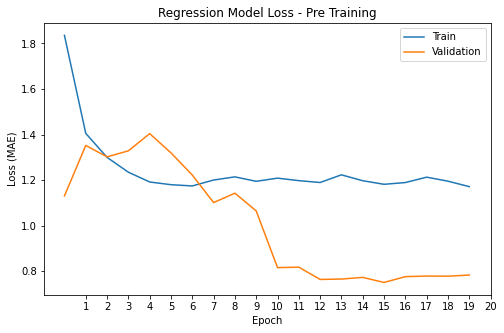

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history['regression_output_loss'])
plt.plot(history['val_regression_output_loss'])
plt.title('Regression Model Loss - Pre Training')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

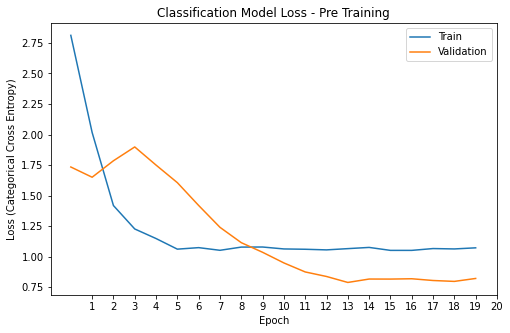

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history['classification_output_loss'])
plt.plot(history['val_classification_output_loss'])
plt.title('Classification Model Loss - Pre Training')
plt.ylabel('Loss (Categorical Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

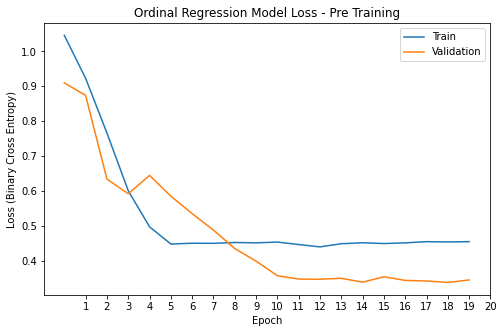

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history['ordinal_regression_output_loss'])
plt.plot(history['val_ordinal_regression_output_loss'])
plt.title('Ordinal Regression Model Loss - Pre Training')
plt.ylabel('Loss (Binary Cross Entropy)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,21))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

## **Stage 2 (Main Training)**


In [ ]:
# Freezing the Encoder Layers Training..(Only Last 14 layers are trainable) for 5 Epochs (Warming up the Weights for Main Training)

for layer in model.layers:
    layer.trainable = False

for i in range(-14,0):
  model.layers[i].trainable = True

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# ref - https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py

'''Below Functions create custom loss functions - Categorical Focal Loss, Binary Focal Loss'''

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [ ]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(loss, axis=1)

    return categorical_focal_loss_fixed

In [ ]:
# ref - https://keras.io/getting-started/functional-api-guide/

model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),
              loss={'regression_output': mean_squared_error, 
                    'classification_output': categorical_focal_loss(alpha=.25, gamma=2) ,
                    'ordinal_regression_output' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              metrics = ['accuracy'])

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=5,
                              callbacks = callback_list,
                              verbose=1).history

model.save("model_main_training.h5")
f = open("history_main_training","wb")
pickle.dump(history,f)
f.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
91/91 [==============================] - 138s 1s/step - loss: 2.4529 - regression_output_loss: 2.2417 - classification_output_loss: 0.0406 - ordinal_regression_output_loss: 0.1706 - regression_output_accuracy: 0.3671 - classification_output_accuracy: 0.6367 - ordinal_regression_output_accuracy: 0.6834 - val_loss: 1.1624 - val_regression_output_loss: 1.0270 - val_classification_output_loss: 0.0243 - val_ordinal_regression_output_loss: 0.1111 - val_regression_output_accuracy: 0.4276 - val_classification_output_accuracy: 0.7301 - val_ordinal_regression_output_accuracy: 0.8253
Epoch 2/5
91/91 [==============================] - 130s 1s/step - loss: 2.4724 - regression_output_loss: 2.2720 - classification_output_loss: 0.0391 - ordinal_regression_output_loss: 0.1612 - regression_output_accuracy: 0.3745 - classification_output_accuracy: 0.6582 - ordinal_regression_output_accuracy: 0.6866 - val_loss: 1.0424 - val_regression_output_loss: 0.9039 - val_classification_output_loss: 0.0275 

In [ ]:
# Now Unfreeze all Layers and make all layers as trainable = True (Train for 45 Epochs)

for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# ref - https://keras.io/getting-started/functional-api-guide/

model.compile(optimizer = optimizers.Adam(lr=LEARNING_RATE),
              loss={'regression_output': mean_squared_error, 
                    'classification_output': categorical_focal_loss(alpha=.25, gamma=2) ,
                    'ordinal_regression_output' : binary_focal_loss(alpha=.25, gamma=2)
                    },
              metrics = ['accuracy'])

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=45,
                              callbacks = callback_list,
                              verbose=1).history

model.save("model_main_training.h5")
f = open("history_main_training","wb")
pickle.dump(history,f)
f.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/45
91/91 [==============================] - 170s 2s/step - loss: 2.3004 - regression_output_loss: 2.0875 - classification_output_loss: 0.0420 - ordinal_regression_output_loss: 0.1709 - regression_output_accuracy: 0.3618 - classification_output_accuracy: 0.6275 - ordinal_regression_output_accuracy: 0.7025 - val_loss: 1.1089 - val_regression_output_loss: 0.9655 - val_classification_output_loss: 0.0286 - val_ordinal_regression_output_loss: 0.1148 - val_regression_output_accuracy: 0.4190 - val_classification_output_accuracy: 0.7116 - val_ordinal_regression_output_accuracy: 0.8040
Epoch 2/45
91/91 [==============================] - 162s 2s/step - loss: 2.4692 - regression_output_loss: 2.2669 - classification_output_loss: 0.0413 - ordinal_regression_output_loss: 0.1611 - regression_output_accuracy: 0.3818 - classification_output_accuracy: 0.6355 - ordinal_regression_output_accuracy: 0.6888 - val_loss: 1.1272 - val_regression_output_loss: 0.9884 - val_classification_output_loss: 0.029

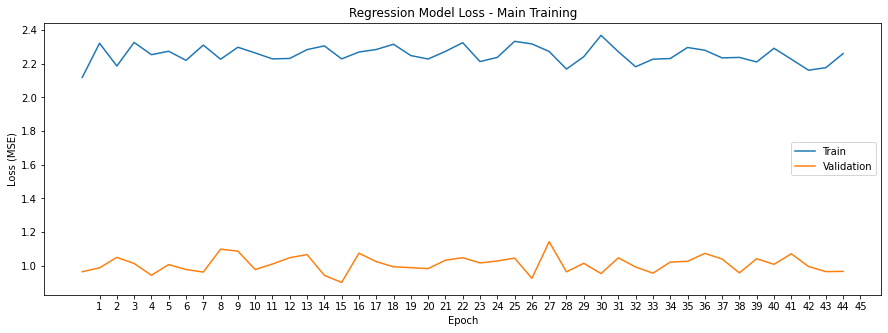

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['regression_output_loss'])
plt.plot(history['val_regression_output_loss'])
plt.title('Regression Model Loss - Main Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,46))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

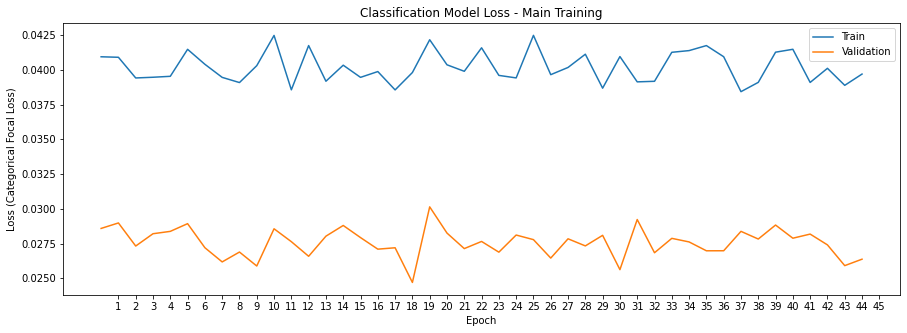

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['classification_output_loss'])
plt.plot(history['val_classification_output_loss'])
plt.title('Classification Model Loss - Main Training')
plt.ylabel('Loss (Categorical Focal Loss)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,46))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

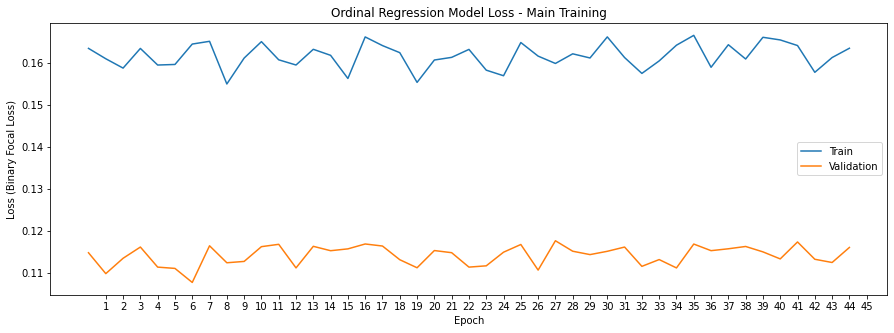

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['ordinal_regression_output_loss'])
plt.plot(history['val_ordinal_regression_output_loss'])
plt.title('Ordinal Regression Model Loss - Main Training')
plt.ylabel('Loss (Binary Focal Loss)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,46))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

## **Stage 3 (Post Training)**


In [ ]:
'''
Get the Outputs from the 3 Heads - (Classification,Regression,Ordinal Regression) to pass the outputs to a new Model
'''

complete_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant')
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
print(complete_generator.n)

new_train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=360,brightness_range=[0.5, 1.5],
                                     zoom_range=[1, 1.2],zca_whitening=True,horizontal_flip=True,
                                     vertical_flip=True,fill_mode='constant')

new_train_generator = new_train_datagen.flow_from_dataframe(dataframe=df_train_new_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          class_mode=None,
                                                          shuffle=False
                                                          )

print(new_train_generator.n)

new_valid_generator = new_train_datagen.flow_from_dataframe(dataframe=df_train_valid,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None
                                                          )
print(new_valid_generator.n)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2929 validated image filenames.
2929
Found 2343 validated image filenames.
2343
Found 586 validated image filenames.
586


In [ ]:
test_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                          directory = "./test_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print(test_generator.n)

Found 733 validated image filenames.
733


In [ ]:
model = load_model("model_main_training.h5",custom_objects={'categorical_focal_loss_fixed':categorical_focal_loss(alpha=.25, gamma=2),
                                                            'binary_focal_loss_fixed' : binary_focal_loss(alpha=.25, gamma=2)})
complete_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)

f = open("complete_preds","wb")
pickle.dump(complete_preds,f)
f.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2929/2929 [==============================] - 2219s 757ms/step


In [ ]:
STEP_SIZE_NEW_TRAIN = new_train_generator.n//new_train_generator.batch_size
new_train_preds = model.predict_generator(new_train_generator, steps=STEP_SIZE_NEW_TRAIN,verbose = 1)

f = open("new_train_preds","wb")
pickle.dump(new_train_preds,f)
f.close()

   3/2343 [..............................] - ETA: 1:32

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2343/2343 [==============================] - 84s 36ms/step


In [ ]:
STEP_SIZE_NEW_VALID = new_valid_generator.n//new_valid_generator.batch_size
new_valid_preds = model.predict_generator(new_valid_generator, steps=STEP_SIZE_NEW_VALID,verbose = 1)

f = open("new_valid_preds","wb")
pickle.dump(new_valid_preds,f)
f.close()

  3/586 [..............................] - ETA: 21s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


586/586 [==============================] - 21s 36ms/step


In [ ]:
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)

f = open("test_preds","wb")
pickle.dump(test_preds,f)
f.close()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


733/733 [==============================] - 562s 767ms/step


In [ ]:
print(complete_preds[0].shape,complete_preds[1].shape,complete_preds[2].shape)

complete_output_regression = np.array(complete_preds[0]).reshape(-1,1)
complete_output_classification = np.array(np.argmax(complete_preds[1],axis = -1)).reshape(-1,1)
complete_output_ordinal_regression = np.array(np.sum(complete_preds[2],axis = -1)).reshape(-1,1)

print(complete_output_regression.shape,complete_output_classification.shape,complete_output_ordinal_regression.shape)
X_complete = np.hstack((complete_output_regression,complete_output_classification,complete_output_ordinal_regression))
print(X_complete.shape)

(2929, 1) (2929, 5) (2929, 5)
(2929, 1) (2929, 1) (2929, 1)
(2929, 3)


In [ ]:
print(new_train_preds[0].shape,new_train_preds[1].shape,new_train_preds[2].shape)

new_train_output_regression = np.array(new_train_preds[0]).reshape(-1,1)
new_train_output_classification = np.array(np.argmax(new_train_preds[1],axis = -1)).reshape(-1,1)
new_train_output_ordinal_regression = np.array(np.sum(new_train_preds[2],axis = -1)).reshape(-1,1)

print(new_train_output_regression.shape,new_train_output_classification.shape,new_train_output_ordinal_regression.shape)
X_train = np.hstack((new_train_output_regression,new_train_output_classification,new_train_output_ordinal_regression))
print(X_train.shape)

(2343, 1) (2343, 5) (2343, 5)
(2343, 1) (2343, 1) (2343, 1)
(2343, 3)


In [ ]:
print(new_valid_preds[0].shape,new_valid_preds[1].shape,new_valid_preds[2].shape)

new_valid_output_regression = np.array(new_valid_preds[0]).reshape(-1,1)
new_valid_output_classification = np.array(np.argmax(new_valid_preds[1],axis = -1)).reshape(-1,1)
new_valid_output_ordinal_regression = np.array(np.sum(new_valid_preds[2],axis = -1)).reshape(-1,1)

print(new_valid_output_regression.shape,new_valid_output_classification.shape,new_valid_output_ordinal_regression.shape)
X_valid = np.hstack((new_valid_output_regression,new_valid_output_classification,new_valid_output_ordinal_regression))
print(X_valid.shape)

(586, 1) (586, 5) (586, 5)
(586, 1) (586, 1) (586, 1)
(586, 3)


In [ ]:
print(test_preds[0].shape,test_preds[1].shape,test_preds[2].shape)

test_output_regression = np.array(test_preds[0]).reshape(-1,1)
test_output_classification = np.array(np.argmax(test_preds[1],axis = -1)).reshape(-1,1)
test_output_ordinal_regression = np.array(np.sum(test_preds[2],axis = -1)).reshape(-1,1)

print(test_output_regression.shape,test_output_classification.shape,test_output_ordinal_regression.shape)
X_test = np.hstack((test_output_regression,test_output_classification,test_output_ordinal_regression))
print(X_test.shape)

(733, 1) (733, 5) (733, 5)
(733, 1) (733, 1) (733, 1)
(733, 3)


In [ ]:
model_post = Sequential()
model_post.add(Dense(1, activation='linear', input_shape=(3,)))
model_post.compile(optimizer=optimizers.SGD(lr=LEARNING_RATE), loss='mean_squared_error', metrics=['mean_squared_error'])
model_post.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(df_train_valid.diagnosis.values.astype(int))

In [ ]:

history = model_post.fit(X_complete,np.array(df_train_train.diagnosis.values.astype(int)),
                         batch_size=BATCH_SIZE,
                         epochs=50,
                         verbose=1,
                         validation_data = (X_test,np.array(df_train_test.diagnosis.values.astype(int))))

model_post.save("model_post_training.h5")
f = open("history_post_training","wb")
#pickle.dump(history,f)
f.close()

Epoch 1/50
92/92 [==============================] - 1s 5ms/step - loss: 9.3968 - mean_squared_error: 9.3968 - val_loss: 5.4347 - val_mean_squared_error: 5.4347
Epoch 2/50
92/92 [==============================] - 0s 3ms/step - loss: 4.8607 - mean_squared_error: 4.8607 - val_loss: 2.8638 - val_mean_squared_error: 2.8638
Epoch 3/50
92/92 [==============================] - 0s 3ms/step - loss: 2.7798 - mean_squared_error: 2.7798 - val_loss: 1.6986 - val_mean_squared_error: 1.6986
Epoch 4/50
92/92 [==============================] - 0s 3ms/step - loss: 1.6371 - mean_squared_error: 1.6371 - val_loss: 1.1651 - val_mean_squared_error: 1.1651
Epoch 5/50
92/92 [==============================] - 0s 3ms/step - loss: 1.1293 - mean_squared_error: 1.1293 - val_loss: 0.9294 - val_mean_squared_error: 0.9294
Epoch 6/50
92/92 [==============================] - 0s 3ms/step - loss: 0.9611 - mean_squared_error: 0.9611 - val_loss: 0.8222 - val_mean_squared_error: 0.8222
Epoch 7/50
92/92 [======================

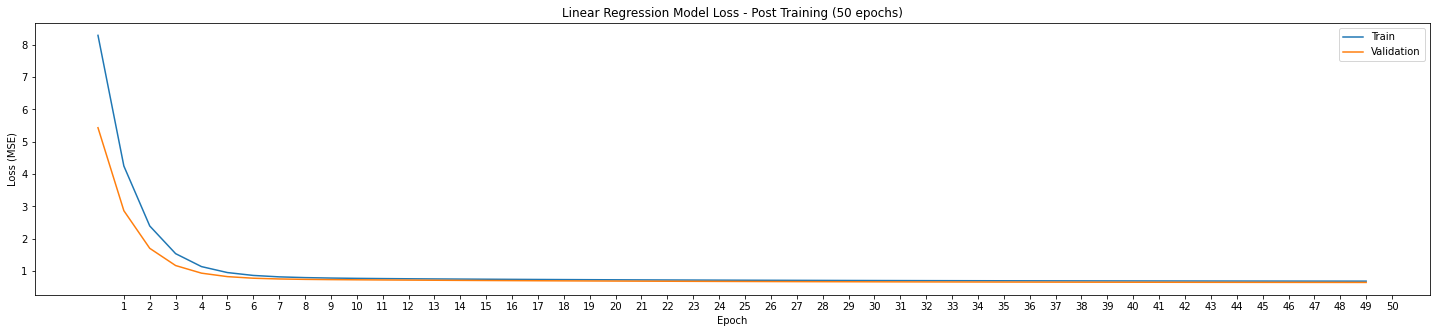

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Linear Regression Model Loss - Post Training (50 epochs)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.xticks(range(1,51))
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

##**Evaluate Model performance (Test data)**

In [ ]:
# ref- https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/63%20-%20ResNet50%20-%20Regression%20-%20RGB%20scale.ipynb
'''This Function does nearest integer rounding for regression output from the post training model'''

def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

In [ ]:
train_labels = model_post.predict(X_complete,batch_size=1,verbose = 1)
train_labels = np.apply_along_axis(classify, 1, train_labels)

2929/2929 [==============================] - 4s 1ms/step


In [ ]:
test_labels = model_post.predict(X_test,batch_size=1,verbose = 1)
test_labels = np.apply_along_axis(classify, 1, test_labels)

733/733 [==============================] - 1s 1ms/step


In [ ]:
# Plot Confusion Matrix..

def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

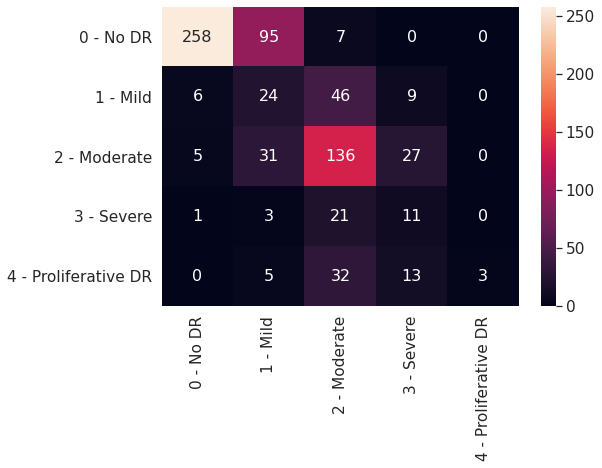

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

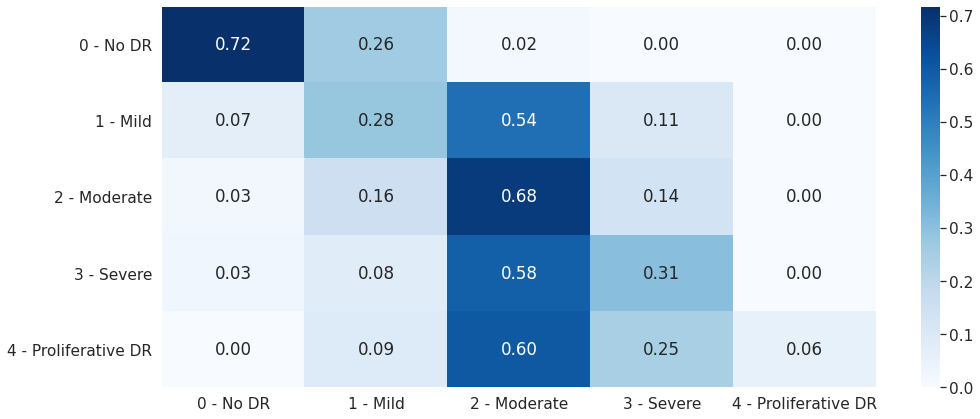

In [ ]:
cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_labels, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_labels))

Train Cohen Kappa score: 0.730
Train Accuracy score : 0.571


In [ ]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.733
Test Accuracy score : 0.589
